For using the data from my drive to colab run this code first and go to the link which will appear, allow access and copy the code and paste in this so that you will be able to retreive the data.

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link = 'https://drive.google.com/open?id=1RL4UDH-FHzVA6lT2vu9SlxqDg2x9vrD2'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1RL4UDH-FHzVA6lT2vu9SlxqDg2x9vrD2


In [3]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ner.csv')

Now our data have been loaded in colab for use.

**Import required library and functions**

In [4]:
import numpy as np 
import pandas as pd


import keras
from keras.models import Sequential, Input, Model
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, TimeDistributed, Flatten
from keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


**For converting dataset into required form**

In [6]:
dataset=df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word','shape'],axis=1)
dataset.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


**For getting word and tags for training**

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
sentences[1]

[('Families', 'O'),
 ('of', 'O'),
 ('soldiers', 'O'),
 ('killed', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('conflict', 'O'),
 ('joined', 'O'),
 ('the', 'O'),
 ('protesters', 'O'),
 ('who', 'O'),
 ('carried', 'O'),
 ('banners', 'O'),
 ('with', 'O'),
 ('such', 'O'),
 ('slogans', 'O'),
 ('as', 'O'),
 ('"', 'O'),
 ('Bush', 'B-per'),
 ('Number', 'O'),
 ('One', 'O'),
 ('Terrorist', 'O'),
 ('"', 'O'),
 ('and', 'O'),
 ('"', 'O'),
 ('Stop', 'O'),
 ('the', 'O'),
 ('Bombings', 'O'),
 ('.', 'O'),
 ('"', 'O'),
 ('Families', 'O'),
 ('of', 'O'),
 ('soldiers', 'O'),
 ('killed', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('conflict', 'O'),
 ('joined', 'O'),
 ('the', 'O'),
 ('protesters', 'O'),
 ('who', 'O'),
 ('carried', 'O'),
 ('banners', 'O'),
 ('with', 'O'),
 ('such', 'O'),
 ('slogans', 'O'),
 ('as', 'O'),
 ('"', 'O'),
 ('Bush', 'B-per'),
 ('Number', 'O'),
 ('One', 'O'),
 ('Terrorist', 'O'),
 ('"', 'O'),
 ('and', 'O'),
 ('"', 'O'),
 ('Stop', 'O'),
 ('the', 'O'),
 ('Bombings', 'O'),
 ('.', 'O'),
 ('"', 'O')]

Getting words

In [9]:
sentences = [[s[0].lower() for s in sent] for sent in getter.sentences]
sentences[1]

['families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banners',
 'with',
 'such',
 'slogans',
 'as',
 '"',
 'bush',
 'number',
 'one',
 'terrorist',
 '"',
 'and',
 '"',
 'stop',
 'the',
 'bombings',
 '.',
 '"',
 'families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banners',
 'with',
 'such',
 'slogans',
 'as',
 '"',
 'bush',
 'number',
 'one',
 'terrorist',
 '"',
 'and',
 '"',
 'stop',
 'the',
 'bombings',
 '.',
 '"']

**Getting tags or labels**

In [10]:
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**Word embedding**

In [11]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [12]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

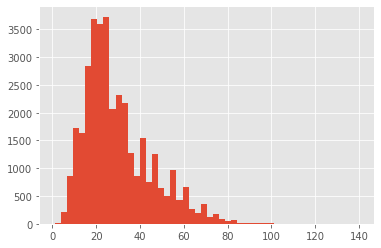

In [13]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [14]:
words = np.array([x.lower() if isinstance(x, str) else x for x in dataset["word"].values])
words = list(set(words))
words.append('unk')
words.append('pad')
n_words = len(words); n_words

27422

In [15]:
tags = list(set(dataset["tag"].values))
n_tags = len(tags)
n_tags

18

In [16]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [17]:
tag2idx

{'B-art': 10,
 'B-eve': 0,
 'B-geo': 17,
 'B-gpe': 8,
 'B-nat': 1,
 'B-org': 9,
 'B-per': 11,
 'B-tim': 12,
 'I-art': 4,
 'I-eve': 15,
 'I-geo': 2,
 'I-gpe': 5,
 'I-nat': 6,
 'I-org': 14,
 'I-per': 13,
 'I-tim': 16,
 'O': 3,
 nan: 7}

In [18]:
word2idx['unk']

27420

**X & y (features and labels)**

In [19]:
X = [[word2idx.get(w,'27420') for w in s] for s in sentences]
X[1]

[17760,
 984,
 16021,
 26140,
 3511,
 5153,
 10230,
 13312,
 5153,
 12179,
 2298,
 11714,
 5480,
 18696,
 6111,
 13305,
 1833,
 16351,
 10361,
 17944,
 179,
 18306,
 16351,
 12058,
 16351,
 25995,
 5153,
 22406,
 11689,
 16351,
 17760,
 984,
 16021,
 26140,
 3511,
 5153,
 10230,
 13312,
 5153,
 12179,
 2298,
 11714,
 5480,
 18696,
 6111,
 13305,
 1833,
 16351,
 10361,
 17944,
 179,
 18306,
 16351,
 12058,
 16351,
 25995,
 5153,
 22406,
 11689,
 16351]

In [20]:
y = [[tag2idx.get(l) for l in lab] for lab in labels]
y[1]

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 11,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 11,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [21]:
X = pad_sequences(maxlen=140, sequences=X, padding="post", value=n_words-1)

In [22]:
word2idx['pad'], n_words-1

(27421, 27421)

In [23]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [24]:
y[1]

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3, 11,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 11,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3], dtype=int32)

In [25]:
X[1]

array([17760,   984, 16021, 26140,  3511,  5153, 10230, 13312,  5153,
       12179,  2298, 11714,  5480, 18696,  6111, 13305,  1833, 16351,
       10361, 17944,   179, 18306, 16351, 12058, 16351, 25995,  5153,
       22406, 11689, 16351, 17760,   984, 16021, 26140,  3511,  5153,
       10230, 13312,  5153, 12179,  2298, 11714,  5480, 18696,  6111,
       13305,  1833, 16351, 10361, 17944,   179, 18306, 16351, 12058,
       16351, 25995,  5153, 22406, 11689, 16351, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421, 27421,
       27421, 27421,

**Data preperation for training**

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [27]:
y_train = keras.utils.to_categorical(y_train)
print(X_train.shape, y_train.shape)

(28141, 140) (28141, 140, 18)


**Bidirectional LSTM model preperation and training**

In [28]:
model = Sequential()

model.add(Embedding(n_words, 50))
model.add(Bidirectional(LSTM(140, return_sequences=True)))
model.add(Bidirectional(LSTM(140, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=150, epochs=5, verbose=1, validation_split=0.2)


Epoch 1/5
151/151 [==============================] - 483s 3s/step - loss: 0.2601 - accuracy: 0.9611 - val_loss: 0.1460 - val_accuracy: 0.9674
Epoch 2/5
151/151 [==============================] - 475s 3s/step - loss: 0.1025 - accuracy: 0.9720 - val_loss: 0.0775 - val_accuracy: 0.9766
Epoch 3/5
151/151 [==============================] - 484s 3s/step - loss: 0.0645 - accuracy: 0.9802 - val_loss: 0.0612 - val_accuracy: 0.9826
Epoch 4/5
151/151 [==============================] - 480s 3s/step - loss: 0.0478 - accuracy: 0.9864 - val_loss: 0.0495 - val_accuracy: 0.9865
Epoch 5/5
151/151 [==============================] - 476s 3s/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.0552 - val_accuracy: 0.9839


**Testing**

In [29]:
pred = model.predict(X_test)

**Visualizing test results**

In [30]:
i = 5
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
the           : O
u.s.          : B-geo
official      : O
stressed      : O
the           : O
only          : O
way           : O
to            : O
successfully  : O
counter       : O
the           : O
threat        : O
is            : O
to            : O
learn         : O
to            : O
work          : O
effectively   : O
together      : O
.             : O
the           : O
u.s.          : B-geo
official      : O
stressed      : O
the           : O
only          : O
way           : O
to            : O
successfully  : O
counter       : O
the           : O
threat        : O
is            : O
to            : O
learn         : O
to            : O
work          : O
effectively   : O
together      : O
.             : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad           : O
pad      

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1371100   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 280)         213920    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 280)         471520    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 18)          5058      
Total params: 2,061,598
Trainable params: 2,061,598
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# input = Input(shape=(140,))
# model = Embedding(n_words, 50)(input)
# model = Bidirectional(LSTM(units=140, return_sequences=True))(model)
# model = Bidirectional(LSTM(units=140, return_sequences=True))(model)
# # reshape = keras.layers.Reshape((-1, 140, 1))(model)

# out = TimeDistributed(Dense(18, activation="softmax"))(model)  # softmax output layer
# model = Model(input, out)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model.fit(X_train, y_train, batch_size=150, epochs=1, verbose=1)